In [1]:
%pylab inline
import os
import keras
import metrics
import numpy as np
import pandas as pd
import seaborn as sns

import keras.backend as K
import glob
from scipy.io import loadmat 
from IPython.display import display, clear_output

from time import time

from keras import callbacks
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
images = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_semantic_90x90.mat")
images = images["semantic"]
labels = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_semantic_90x90_labels.mat")
labels = labels["labels"]

In [3]:
images.shape

(3704, 8100)

In [4]:
# Assign ground truth labels
labels_gt = labels[0]
# Split dataset into tarin and test
x_train = images[:3000] / 255.0
x_test  = images[-704:] / 255.0
y_train = labels_gt[:3000]
y_test  = labels_gt[-704:]

In [5]:
set(labels_gt)

{0, 1, 2, 3, 4, 5}

In [6]:
def get_room_type(label):
    if label == 0: return 'WC'
    if label == 1: return 'conferenceRoom'
    if label == 2: return 'hallway'
    if label == 3: return 'lounge'
    if label == 4: return 'office'
    if label == 5: return 'storage'

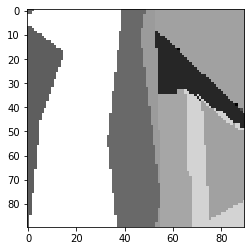

Room type: office


In [7]:
i = 1234
pylab.imshow(x_train[i].reshape(90, 90), cmap='gray')
pylab.show()
print('Room type: ' + get_room_type(y_train[i]))

### KMeans Beasic Implementation

In [8]:
km = KMeans(n_jobs=-1, n_clusters = 6, n_init=20)

In [9]:
km.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=20, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [10]:
pred = km.predict(x_test)

In [11]:
set(pred)

{0, 1, 2, 3, 4, 5}

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

normalized_mutual_info_score(y_test, pred)

0.10249780416897661

### Autoencoder + KMeans

In [13]:
# this is our input placeholder
input_img = Input(shape=(8100,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(30, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(8100)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8100)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               4050500   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 30)                60030     
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              62000     
_________________________________________________________________
dens

In [14]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [15]:
train_history = autoencoder.fit(x_train, x_train,
                                epochs=10,
                                batch_size=32,
                                shuffle=True,
                                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 3000 samples, validate on 704 samples
Epoch 1/10
3000/3000 [==============================] - 11s 4ms/step - loss: 2.5535e-06 - val_loss: 2.9046e-08
Epoch 2/10
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0172e-08 - val_loss: 2.8800e-08
Epoch 3/10
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0237e-08 - val_loss: 2.9024e-08
Epoch 4/10
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0293e-08 - val_loss: 2.8898e-08
Epoch 5/10
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0319e-08 - val_loss: 2.9022e-08
Epoch 6/10
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0378e-08 - val_loss: 2.8886e-08
Epoch 7/10
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0409e-08 - val_loss: 2.8978e-08
Epoch 8/10
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0534e-08 - val_loss: 2.9047e-08
Epoch 9/10
3000/3000 [==

In [16]:
pred_auto_train = encoder.predict(x_train)
pred_auto = encoder.predict(x_test)

In [17]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

In [18]:
set(pred)

{0, 1, 2, 3, 4, 5}

In [19]:
normalized_mutual_info_score(y_test, pred)

0.09322916215015713

### ConvAutoencoder + KMeans (currently not working, in progress...)

In [ ]:
# Reshape the images
x_train_s = x_train.reshape(-1,90,90,1)
x_test_s  = x_test.reshape(-1,90,90,1)

In [ ]:
x_test_s[0].shape

In [ ]:
# Build the autoencoder
model = Sequential()
model.add(Conv2D(45, kernel_size=3, padding='same', activation='relu', input_shape=(90,90,1)))
model.add(MaxPool2D((3,3), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(15, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((3,3), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(15, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((3,3)))
model.add(Dropout(0.2))
model.add(Conv2D(45, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((3,3)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()

In [ ]:
# Train the model
model.fit(x_train_s, x_train_s, epochs=10, batch_size=64, validation_data=(x_test_s, x_test_s), verbose=1)

In [ ]:
# Fitting testing dataset
restored_testing_dataset = model.predict(x_test_s)

In [ ]:
# Observe the reconstructed image quality
plt.figure(figsize=(20,5))
for i in range(5):
    index = y_test.tolist().index(i)
    plt.subplot(2, 6, i+1)
    plt.imshow(x_test_s[index].reshape((90,90)), cmap='gray')
    plt.gray()
    plt.subplot(2, 6, i+7)
    plt.imshow(restored_testing_dataset[index].reshape((90,90)), cmap='gray')
    plt.gray()

In [ ]:
# Extract the encoder
encoder = K.function([model.layers[0].input], [model.layers[4].output])

In [ ]:
# Encode the training set
encoded_images = encoder([x_test_s])[0].reshape(-1, 10*10*15)

In [ ]:
encoded_images.shape

In [ ]:
# Cluster the training set
kmeans = KMeans(n_clusters = 6)
clustered_training_set = kmeans.fit_predict(encoded_images)

In [ ]:
# Observe and compare clustering result with actual label using confusion matrix
cm = confusion_matrix(y_test, clustered_training_set)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Clustering label', fontsize=15)
plt.show()

In [ ]:
# Plot the actual pictures grouped by clustering
fig = plt.figure(figsize=(20,20))
for r in range(6):
    cluster = cm[r].argmax()
    for c, val in enumerate(x_test_s[clustered_training_set == cluster][0:6]):
        fig.add_subplot(6, 6, 6*r+c+1)
        plt.imshow(val.reshape((90,90)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(r))

In [ ]:
normalized_mutual_info_score(y_test, clustered_training_set)

### Deep Embedded Clustering (DEC) implementation

In [20]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

In [21]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=6))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=6,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: ', time() - t0)
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred

In [22]:
import sys
sys.path.insert(0, 'Deep_Embedding_Clustering')
from Deep_Embedding_Clustering import metrics

# setting the hyper parameters
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
dataset = 'mnist'
batch_size = 32
maxiter = 2e4
tol = 0.001
save_dir = 'results'

import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

update_interval = 200
pretrain_epochs = 50
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
#pretrain_optimizer = SGD(lr=1, momentum=0.9)


# prepare the DEC model
dec = DEC(dims=[x_train.shape[-1], 500, 500, 2000, 10], n_clusters=6, init=init)

dec.pretrain(x=x_train, y=y_train, optimizer=pretrain_optimizer,
             epochs=pretrain_epochs, batch_size=batch_size,
             save_dir=save_dir)

...Pretraining...
Epoch 1/50
3000/3000 [==============================] - 9s 3ms/step - loss: 3.9507e-08
        |==>  acc: 0.2967,  nmi: 0.0597  <==|
Epoch 2/50
  64/3000 [..............................] - ETA: 7s - loss: 2.9055e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.0445e-08
Epoch 3/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0401e-08
Epoch 4/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0723e-08
Epoch 5/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0595e-08
Epoch 6/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0635e-08
        |==>  acc: 0.2983,  nmi: 0.0841  <==|
Epoch 7/50
  64/3000 [..............................] - ETA: 7s - loss: 3.0790e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.0825e-08
Epoch 8/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0780e-08
Epoch 9/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0871e-08
Epoch 10/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0877e-08
Epoch 11/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0748e-08
        |==>  acc: 0.3137,  nmi: 0.0947  <==|
Epoch 12/50
  64/3000 [..............................] - ETA: 6s - loss: 2.7333e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.0831e-08
Epoch 13/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0875e-08
Epoch 14/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0894e-08
Epoch 15/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0969e-08
Epoch 16/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0907e-08
        |==>  acc: 0.3313,  nmi: 0.1041  <==|
Epoch 17/50
  64/3000 [..............................] - ETA: 6s - loss: 3.1664e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.0909e-08
Epoch 18/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0918e-08
Epoch 19/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0862e-08
Epoch 20/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0940e-08
Epoch 21/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0867e-08
        |==>  acc: 0.3337,  nmi: 0.1064  <==|
Epoch 22/50
  64/3000 [..............................] - ETA: 7s - loss: 2.8539e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.1055e-08
Epoch 23/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0975e-08
Epoch 24/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1143e-08
Epoch 25/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0867e-08
Epoch 26/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0809e-08
        |==>  acc: 0.3363,  nmi: 0.1070  <==|
Epoch 27/50
  64/3000 [..............................] - ETA: 7s - loss: 3.3621e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.0997e-08
Epoch 28/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1132e-08
Epoch 29/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1201e-08
Epoch 30/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1061e-08
Epoch 31/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1130e-08
        |==>  acc: 0.3337,  nmi: 0.1068  <==|
Epoch 32/50
  64/3000 [..............................] - ETA: 6s - loss: 2.9165e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.1021e-08
Epoch 33/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1057e-08
Epoch 34/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0966e-08
Epoch 35/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1179e-08
Epoch 36/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0988e-08
        |==>  acc: 0.3337,  nmi: 0.1065  <==|
Epoch 37/50
  64/3000 [..............................] - ETA: 6s - loss: 3.0946e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.1172e-08
Epoch 38/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1002e-08
Epoch 39/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1213e-08
Epoch 40/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1081e-08
Epoch 41/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1022e-08
        |==>  acc: 0.3357,  nmi: 0.1075  <==|
Epoch 42/50
  64/3000 [..............................] - ETA: 6s - loss: 3.1962e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.1022e-08
Epoch 43/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1094e-08
Epoch 44/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0915e-08
Epoch 45/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.1028e-08
Epoch 46/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0908e-08
        |==>  acc: 0.3353,  nmi: 0.1083  <==|
Epoch 47/50
  64/3000 [..............................] - ETA: 6s - loss: 2.9792e-08

c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


3000/3000 [==============================] - 7s 2ms/step - loss: 3.0937e-08
Epoch 48/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0967e-08
Epoch 49/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0816e-08
Epoch 50/50
3000/3000 [==============================] - 7s 2ms/step - loss: 3.0952e-08
Pretraining time:  362.979736328125
Pretrained weights are saved to results/ae_weights.h5


In [23]:
dec.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 8100)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               4050500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 6)                 60        
Total params: 5,323,070
Trainable params: 5,323,070
Non-trainable params: 0
_________________________________________________________________


In [24]:
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [25]:
y_pred = dec.fit(x_train, y=y_train, tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)

Update interval 200
Save interval 468.75
Initializing cluster centers with k-means.


c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Iter 0: acc = 0.36867, nmi = 0.07789, ari = 0.00981  ; loss= 0
saving model to: results/DEC_model_0.h5
Iter 200: acc = 0.36867, nmi = 0.07789, ari = 0.00981  ; loss= 0
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.
saving model to: results/DEC_model_final.h5


c:\python368-64\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [26]:
pred_val = dec.predict(x_test)

In [27]:
set(pred_val)

{0, 1, 2}

In [28]:
normalized_mutual_info_score(y_test, pred_val)

0.07305634730107706